In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import lib, data, model
import graphs as gr
 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

<h3>Part 1: Getting the Data</h3>

In [327]:
# breaking into diff files due to API call limits of 100 per hour ---->
# CV 5262 - FILE 1
# LA 691  | PE 1857 | SK 593 - FILE 2
# CF 3886 | RG 3772 | BS 2074 - FILE 3
# SO 3807 | DN 1310 | EX 1211 | PO 2582 - FILE 4
# LE 2890 |  LS 7000 - FILE 5
# NG 3149 |  YO 753 | BA 1056 - FILE 6
# M1 TO 50 - FILE 7
# Sheffield 2528 | Birmingham 4794 - FILE 8
# Liverpool 3300 ish - File 9

# postcodes = ['liverpool']
# df9 = data.getRegionalData(postcodes,'20200117',9)


In [19]:
concatenated_df = data.joinData()

In [21]:
# concatenated_df.head()

In [22]:
# cleaning the dataset
df = data.cleanData(concatenated_df)
df.shape

(74068, 21)

<h3>Part 2:EDA</h3>

<h4>Question 1: Where should I buy?</h4>

9     London
10    London
15    London
17    London
18    London
Name: post_town, dtype: object

<h4>Question 2: Where type of houses should I buy?</h4>

In [30]:
region = df
# region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]


includes = ['Bristol']

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

region['include'] = region['post_town'].apply(matcher)

region = region[region['include']==1]
region.shape

(1059, 22)

In [28]:
grouped = data.getPerBedroomOvreview(region)

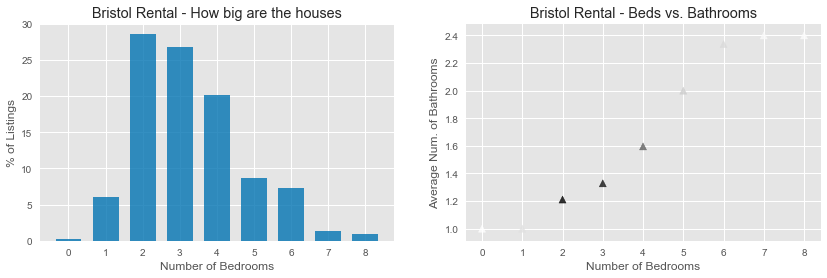

In [33]:

sns.set_palette("colorblind")
title = 'Bristol'
gr.areaOverview(grouped,title)

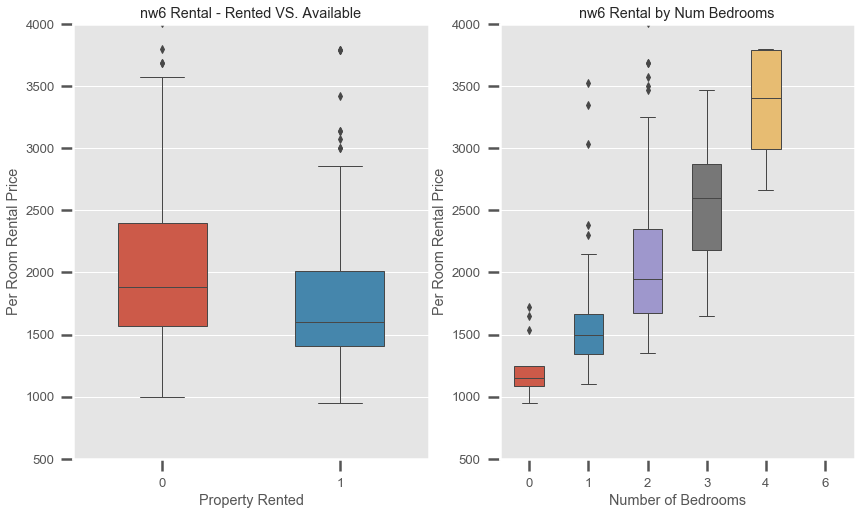

In [99]:
gr.rentPriceGraphs(region,title,'rent_price',500,4_000)

In [106]:
# gr.rentPriceBedBath(region,title,'rent_price',500,4_000)

In [107]:
data.getBathroomsByProperSize(region)

,num_bedrooms,num_bathrooms,count,proportion%,rent_pm
0,0,0,4,26.7,1083.0
1,0,1,11,73.3,1150.0
2,1,0,20,17.2,1462.5
3,1,1,93,80.2,1500.0
4,1,2,3,2.6,2150.0
5,2,0,28,17.1,954.0
6,2,1,59,36.0,838.0
7,2,2,77,47.0,1105.0
8,3,0,20,37.7,946.0
9,3,1,16,30.2,738.5


<h5>Part 3: Feature Engineer</h5>

In [293]:
pd.set_option('display.max_colwidth', 200)
# region[(region['room']==1)]

In [2]:
# df.post_town.value_counts()

# print(region.shape)

In [414]:
df[df['county']== 'North Yorkshire'].post_town.value_counts()

York           413
Scarborough     85
Selby           53
Malton          52
Thirsk          23
Pickering       11
Tadcaster        7
Whitby           6
Filey            6
Name: post_town, dtype: int64

<h5>Part 4: Modelling</h5>

In [10]:
region = df
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]

# R2 80% for all, 80% for students
south_west = ['Bristol','Bath & N E Somerset','Wiltshire','North Somerset','Somerset',
           'Hampshire','Southampton','Devon',
           'Berkshire','West Berkshire',
             'Cardiff']

# R2 76% for all, 76% for students
north_west = ['Greater Manchester','Merseyside','Lancashire']

# R2 72% for all, 72% for students - POST_TOWN
midlands = ['Coventry','Leamington Spa','Peterborough']

# R2 63% for all, 42% for students
north_east = ['West Yorkshire','South Yorkshire','North Yorkshire']

includes = south_west

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

region['include'] = region['post_town'].apply(matcher)

region = region[region['include']==1]


print(region.shape)

(1464, 22)


Training r^2 %: 82.76
Testing r^2 %: 78.501
Training MSE (mil): 0.12207769192887907
Testing MSE (mil): 0.14747849442290872
----------
Training r^2 %: 90.405
Testing r^2 %: 83.597
Training MSE (mil): 0.06794281489562988
Testing MSE (mil): 0.11251713735795454
----------
Training r^2 %: 90.139
Testing r^2 %: 83.877
Training MSE (mil): 0.06982509152548307
Testing MSE (mil): 0.11059746187357844


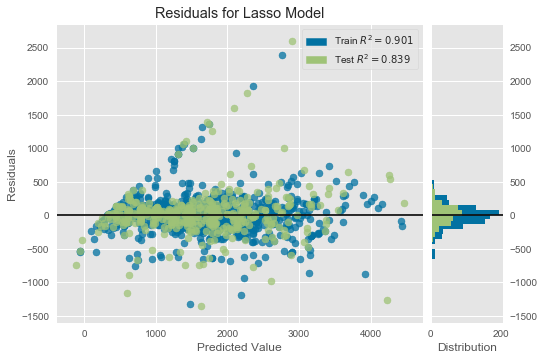

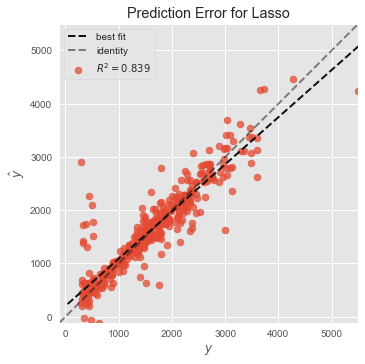

In [11]:
# trouble_postcodes = ['SW1','W1C','SW1A','W1K','W1J','W1','W1S','EN6','EC3R','SW1X']
# for outcode in trouble_postcodes:
#     region.drop(region[region['outcode'] == outcode].index, inplace=True)


X = region.drop(columns=['rent_price','listing_id','description','details_url',
                         'first_published_date','outcode','room_pm','student','county','post_town'])
y = region['rent_price']

run = model.ModelTry(X,y)


## Perform a first naive linear regression model using only Continious Data Variables
lin_con, coef1, X_train, y_train = run.run_model(1, False, False)
print("----------")

## add in the categorical variables ---- OVERFITTING with outcode
# lin_reg, coef2, X_train, y_train = run.run_model(2, False, False)
# print("----------")

## add in the polynomial interactions, CHECK effects of overfitting here
lin_poly, coef3, X_train, y_train = run.run_model(2, False, True)
print("----------")

## use Lasso model
las, coef4, X_train, y_train = run.run_model(3, True, True)

In [12]:
coef4.sort_values('coef_abs', ascending=False).head()

,coef_value,coef_abs
num_bathrooms,664.933193,664.933193
latitude^2,-611.326533,611.326533
latitude num_bathrooms,464.058500,464.058500
furnished_state num_bathrooms,449.693343,449.693343
furnished_state_Missing,259.677551,259.677551


<h5>Part 5: NLP</h5>

In [6]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [8]:
region['tokens'] = region['description'].map(lambda x: tokenizer.tokenize(x))

NameError: name 'region' is not defined

In [9]:
stop_words=set(stopwords.words("english"))

def remove_stopwords(x):
    filtered = []
    for word in x:
        if word not in stop_words:
            filtered.append(word)
    return filtered

region['tokens_clean'] = region['tokens'].map(lambda x: remove_stopwords(x))

NameError: name 'region' is not defined

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import RegexpTokenizer

# token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# text_counts= cv.fit_transform(df['description'])

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['description'])
text_tf.data

array([0.04253779, 0.21467509, 0.10815693, ..., 0.42108408, 0.28056201,
       0.25115235])

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 

def fn_tdm_df(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    vectorizer = CountVectorizer(**kwargs)
    x1 = vectorizer.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = vectorizer.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df

In [14]:
# what about this function?
def fn_tdm_tfidf(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    tf = TfidfVectorizer(**kwargs)
    x1 = tf.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = tf.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df

In [16]:
# fn_tdm_tfidf(df['description']).transpose()

,00,000,000802to,000a,000council,000entrance,000epc,000no,000pa,000rent,...,非常的稀少,非常适合喜欢纯正英伦风格同学们,风景好,ﬁnd,ﬂat,ﬂoor,ﬂooring,𝘤𝘰𝘮,𝘤𝘰𝘮two,𝘨𝘮𝘢𝘪𝘭
0,0.0,0.183436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h5>Part 6: Clustering</h5>